In [85]:
import pandas as pd
import numpy as np
import os
from PIL import Image
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import seaborn as sns

# Baseline Model
In this notebook, we will create a baseline logistic regression model as a basis for comparison to evaluate the performance of the neural networks to be studied in later notebooks.

In [2]:
root = 'data/train'

In [3]:
birds = os.listdir(root)
birds = [bird for bird in birds if bird[0]!='.']

## Convert image to 1D vector
Each image needs to be a single vector containing the RGB values for each pixel. Assemble a 2D matrix with one row per image and one column per pixel.

In [4]:
test_img_path = os.listdir(root+f'/{birds[0]}')[0]
test_img_path = root+f'/{birds[0]}' + f'/{test_img_path}'
test_img = Image.open(test_img_path)

In [5]:
# How many pixels are there (i.e. columns)?
dimension = np.array(test_img).reshape(-1).shape[0]
dimension

150528

Due to the enormous size of the training matrix that would result, we will limit the baseline model to 5 species and assume the performance will be the same for the rest.

In [13]:
# How many total images are there?

def image_count(num_species, root): # Counts the number of training images for a set number of species
    num_images = 0
    for i, bird in enumerate(birds):
        if i == num_species: break
        num_images += len(os.listdir(root + f'/{bird}'))
    return num_images

In [14]:
image_count(5, root)

827

In [15]:
# Initialize a 2D matrix with dimensions equal to number of images x number of pixels

# Starting with 5 species.
image_repo = np.zeros([image_count(5, root),dimension])

In [59]:
def img_vectorization(num_species, root): # Assemble 2D matrix with RGB pixel values as columns and images as rows
    
    # Initialize a 2D matrix with dimensions equal to number of images x number of pixels
    image_repo = np.zeros([image_count(num_species, root),dimension])   
#     return image_repo.shape
    count = 0
    name = []
    for i, bird in enumerate(birds):
        images = os.listdir(root + f'/{bird}')
        for image in images:
            img = Image.open(root + f'/{bird}' + f'/{image}')
            row = np.array(img).reshape(-1)
            image_repo[count, :] = row
            name.append(bird)
            img.close()
            count += 1

        if i == num_species - 1: return image_repo, name
#             if count%5000==0: print (count/num_images)
    return image_repo, name

In [60]:
result, names = img_vectorization(5, root)

In [61]:
result

array([[ 32.,  43.,  27., ...,  59.,  78.,  48.],
       [222., 231., 228., ..., 226., 232., 230.],
       [122., 150.,  73., ...,  61.,  70.,  49.],
       ...,
       [150., 175., 195., ..., 161., 171., 207.],
       [ 66.,  71.,  39., ...,  53.,  59.,  31.],
       [ 64.,  85.,  52., ..., 121., 147.,  73.]])

In [52]:
result.shape

(827, 150528)

This is the correct shape.

In [63]:
len(names)

827

Repeat with validation data

In [64]:
root_valid = 'data/valid'
result_valid, names_valid = img_vectorization(5, root_valid)

## Truncated SVD
The high number of dimensions means baseline modeling will be extremely slow. Convert all the images to 2D using T-SVD. The results will go into a multiclass logistic regression model.

In [72]:
scaler = StandardScaler()
X_train = scaler.fit_transform(result)
X_val = scaler.transform(result_valid)

In [73]:
svd = TruncatedSVD(n_components=2)

result_2d = svd.fit_transform(X_train)
result_valid_2d = svd.transform(X_val)

In [74]:
print(result_2d.shape)
print(result_valid_2d.shape)

(827, 2)
(25, 2)


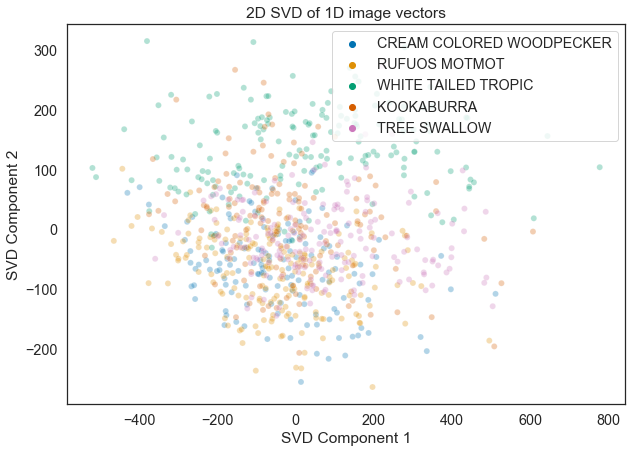

In [83]:
# Adapted from NeuralNet_Features_TransferLearning.ipynb from Metis
sns.set(style='white', rc={"figure.figsize":(10, 7)}, font_scale=1.3)
sns.scatterplot(x=result_2d[:, 0], y=result_2d[:, 1],
                hue=names, alpha=.3,
                palette=sns.color_palette("colorblind", 5))
plt.xlabel("SVD Component 1")
plt.ylabel("SVD Component 2")
plt.title("2D SVD of 1D image vectors");
plt.legend(loc='upper right');

There does appear to be some separation. For example, green dots and blue dots appear separated.

## Logistic Regression baseline model

In [88]:
lr = LogisticRegression(multi_class = 'multinomial', solver = 'lbfgs')
lr.fit(result_2d, names)
score = lr.score(result_valid_2d, names_valid)
print(f'Score = {score} \n This is the number to beat')

Score = 0.32 
 This is the number to beat


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## Repeat baseline model with more species

In [89]:
# Repeat above steps but for 15 species
result, names = img_vectorization(15, root)
result_valid, names_valid = img_vectorization(15, root_valid)

In [90]:
scaler = StandardScaler()
X_train = scaler.fit_transform(result)
X_val = scaler.transform(result_valid)

In [91]:
svd = TruncatedSVD(n_components=2)

result_2d = svd.fit_transform(X_train)
result_valid_2d = svd.transform(X_val)

In [92]:
lr = LogisticRegression(multi_class = 'multinomial', solver = 'lbfgs')
lr.fit(result_2d, names)
score = lr.score(result_valid_2d, names_valid)
print(f'Score = {score} \n This is the number to beat')

Score = 0.14666666666666667 
 This is the number to beat


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


The score gets worse as you go from 5 classes to 15, likely because it gets increasingly difficult to draw a line distinguishing classes the more classes there are. It stands to reason that a conventional model like Logistic Regression will not be able to identify classes with 50 species, let alone 400, and so we turn to convolutional neural networks in the next notebook.